<a href="https://colab.research.google.com/github/mich3leRusso/Weather-Forecasting/blob/main/Weather_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Programming and Forecasting Task #


In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.descriptivestats import Description
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.cm as cm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

## Open the dataset ##

In [ ]:
filename = "dly1475.csv"
# Read the first few lines manually
with open(filename, "r") as f:
    lines = [next(f).strip() for _ in range(5)]  # read first 5 lines
# Extract metadata
station_name = lines[0].split(":")[1].split(",")[0].strip()
station_height = lines[1].split(":")[1].split(",")[0].strip()
latitude = lines[2].split(":")[1].split(",")[0].strip()
print("CSV Metadata")
print(f"Station Name: {station_name}")
print(f"Station Height: {station_height}")
print(f"Latitude: {latitude}\n ")
df=pd.read_csv(filename, header=24)
#number of columns and number of rows
print("Size of the dataset\n", df.shape, "\n")
#print the name of the headers
print("Headers of the dataset\n")
for i, col in enumerate(df.columns):
    print(f"{i:>3} → {col}")
date1_str = df.iloc[0, 0]
date2_str = df.iloc[-1, 0]
print("\n Date of the first Observation\n", date1_str, "\n")
print("Date of the second Observation\n ", date2_str, "\n")
#number of years of measurement
date_format = "%d-%b-%y"
date1 = datetime.strptime(date1_str, date_format)
date2 = datetime.strptime(date2_str, date_format)
# Calculate difference
delta = date2 - date1
print("Difference in days:", delta.days)

CSV Metadata
Station Name: GURTEEN
Station Height: 75 M
Latitude: 53.035
 
Size of the dataset
 (5661, 17) 

Headers of the dataset

  0 → date
  1 → maxtp
  2 → mintp
  3 → gmin
  4 → rain
  5 → cbl
  6 → wdsp
  7 → hm
  8 → ddhm
  9 → hg
 10 → soil
 11 → pe
 12 → evap
 13 → smd_wd
 14 → smd_md
 15 → smd_pd
 16 → glorad

 Date of the first Observation
 01-Oct-09 

Date of the second Observation
  31-Mar-25 

Difference in days: 5660


This dataset represents meteorological observations recorded at the **GURTEEN** weather station.  
The file includes metadata such as:

- **Station Name:** GURTEEN  
- **Station Height:** 75 m  
- **Latitude:** 53.035  

The observations are taken daily from 1st October 2009 to 31st March 2025, covering a total of 5,660 days. This means that the measurements also capture seasonal variations, allowing for the analysis of patterns and trends that occur throughout the year

## EDA Analysis  ##
 Analyzing and visualizing data in order to summarize their main characteristics and gain relevant information from them. The steps that i decided to involve in this analysis are:

 - Yearly Seasonal Plots
 - Monthly Box Plots  
 - Time Series Decomposition
 - Correlation between features

### Base metrics ###
I used a data descriptor to compute key statistics (mean, standard deviation, median, etc.) for the numerical features in my dataset. This helped me understand the range and distribution of each variable, detect potential outliers through the standard deviation or MAD, and identify missing values that might need cleaning.

By reviewing the summary, I could determine:

- Which features have missing data and need imputation or removal.

- Which features are on different scales and might require normalization or standardization.

- The overall variability of each feature, which can indicate which variables may dominate model behavior or need transformation.



In [ ]:
df['date'] = pd.to_datetime(df.iloc[:, 0])
df_numeric = df.iloc[:, 1:]

/tmp/ipython-input-1851041002.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df.iloc[:, 0])


In [ ]:
# Add Year and Month columns
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month
df_numeric = df.iloc[:, 1:17]
cols = df_numeric.columns
#force the conversion to int or float
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df=df.dropna()
print(f"New shape: {df.shape}")

New shape: (5648, 19)


In [ ]:
dataset_descriptor=Description(df.iloc[:,1:17], stats=["missing", "mean", "std", "mad", "median"], )
dataset_descriptor.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

According to the dataset description, several variables exhibit relatively high values of both MAD (Mean Absolute Deviation) and standard deviation, indicating a high degree of variability or sparsity in their distributions over time. In particular, features such as smd_wd (13), smd_md (14), smd_pd (15), glorad (16), and hm (7) show significant dispersion compared to the others.

This variability suggests that these features may fluctuate substantially across observations or time periods, reflecting underlying environmental or temporal dynamics.

This also suggests that all the features doesn't have the same ranges , and it is really important to normalize them.

### Yearly Seasonal Plots ###
are valuable tools for identifying recurring patterns and temporal dynamics within time-series data. By visualizing data from multiple years on the same season.

They help reveal seasonal trends, such as consistent peaks or troughs occurring in the same months each year, as well as anomalies or irregularities that deviate from typical seasonal behavior.

Due to the large number of data points collected daily, I decided to calculate the monthly mean for each feature within every year.

/tmp/ipython-input-406236210.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(years))


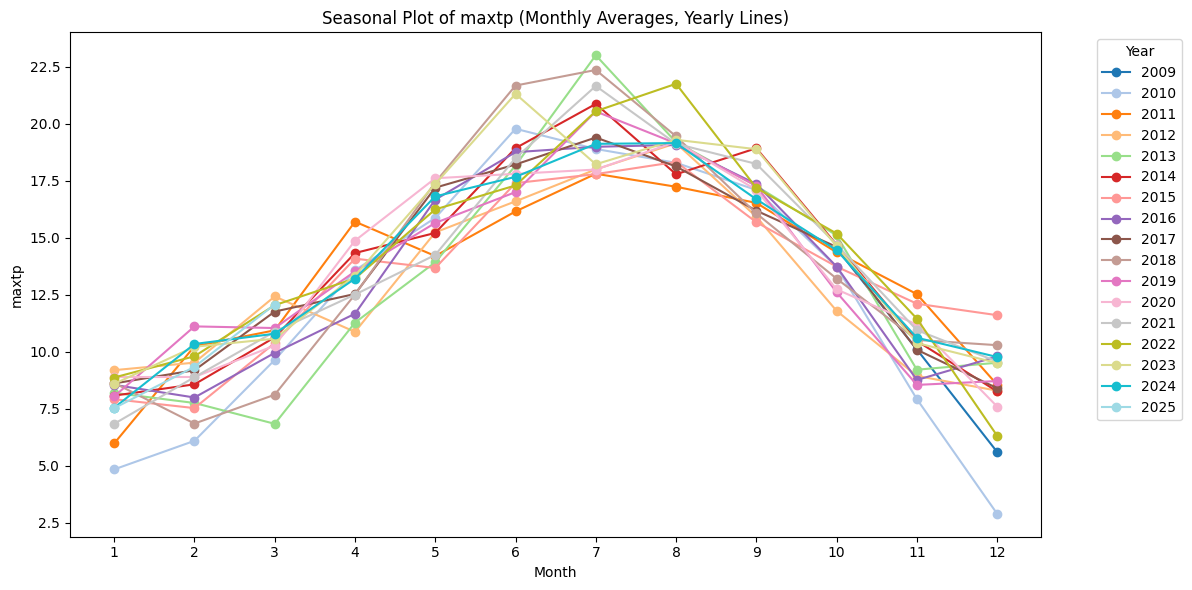

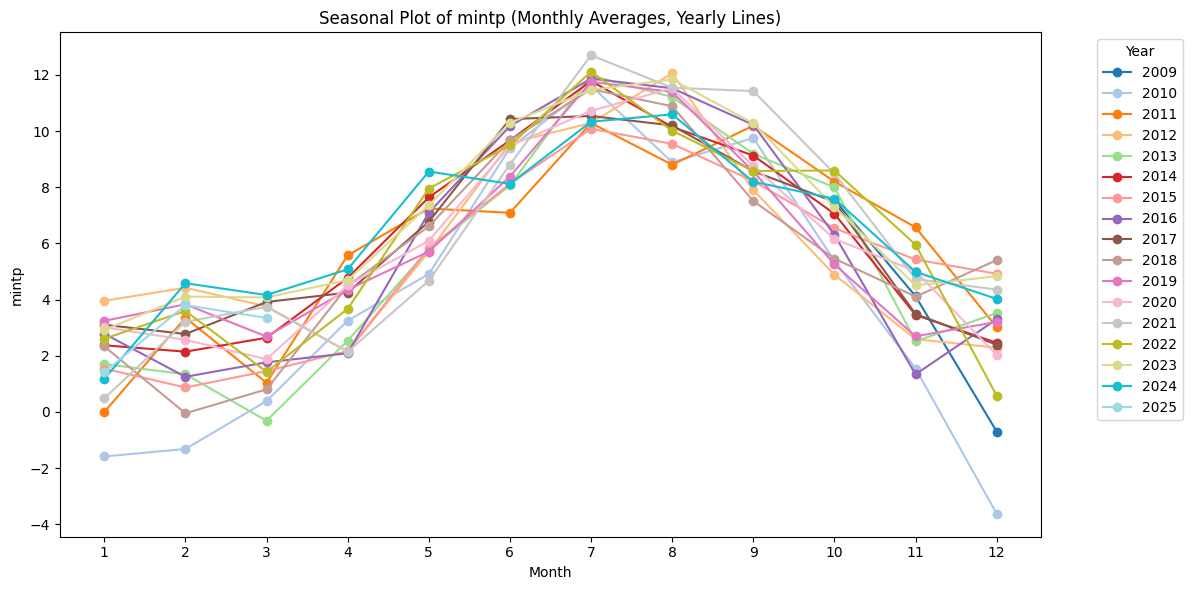

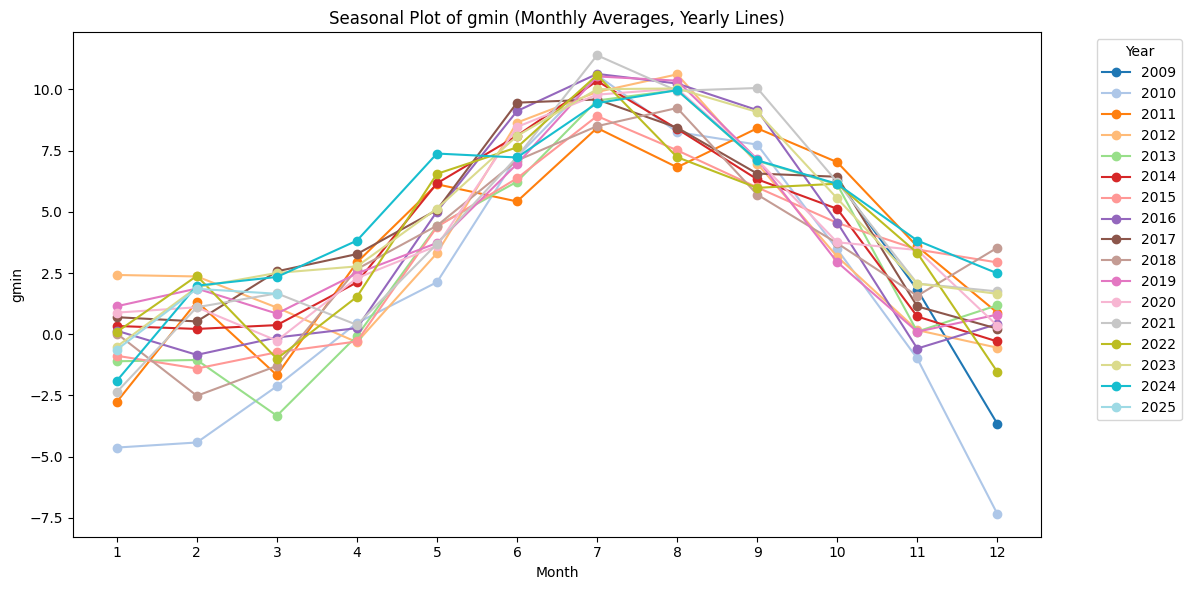

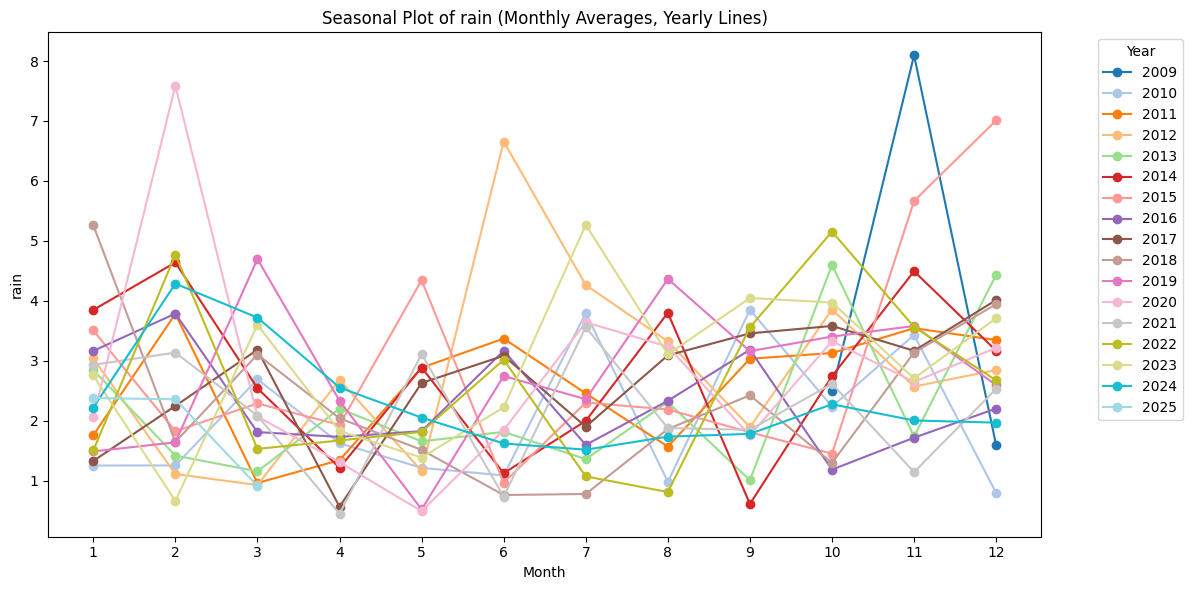

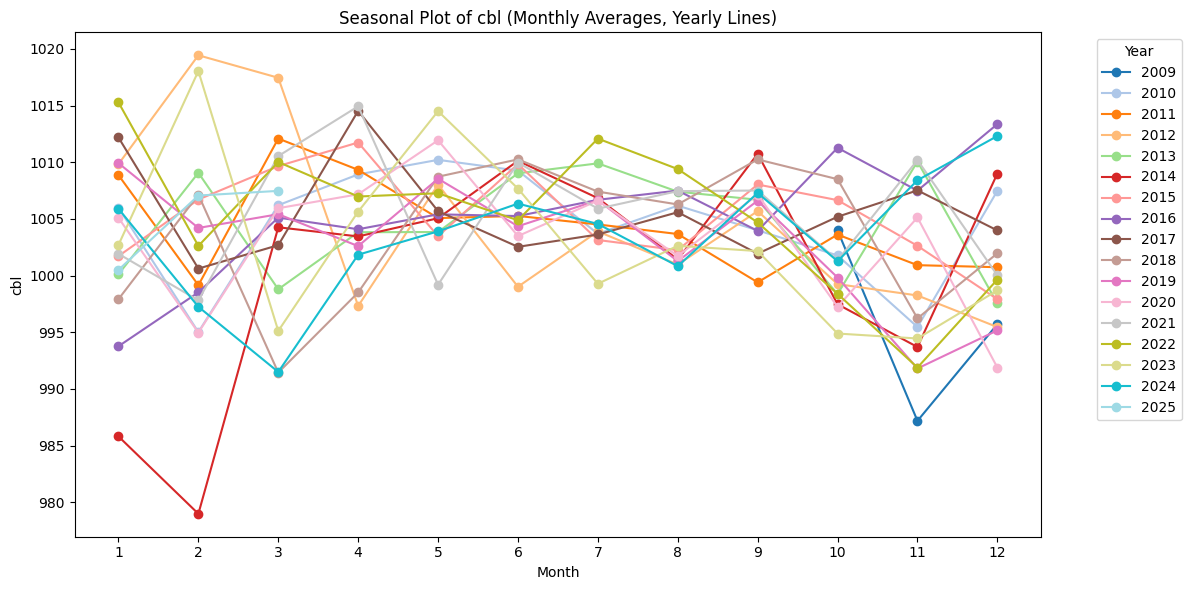

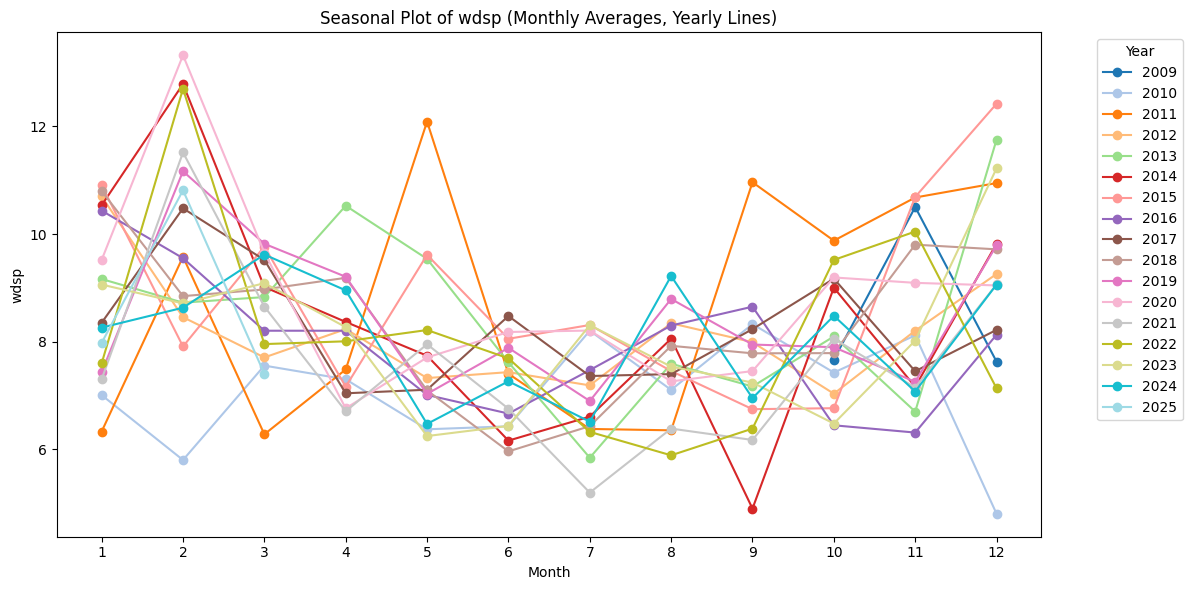

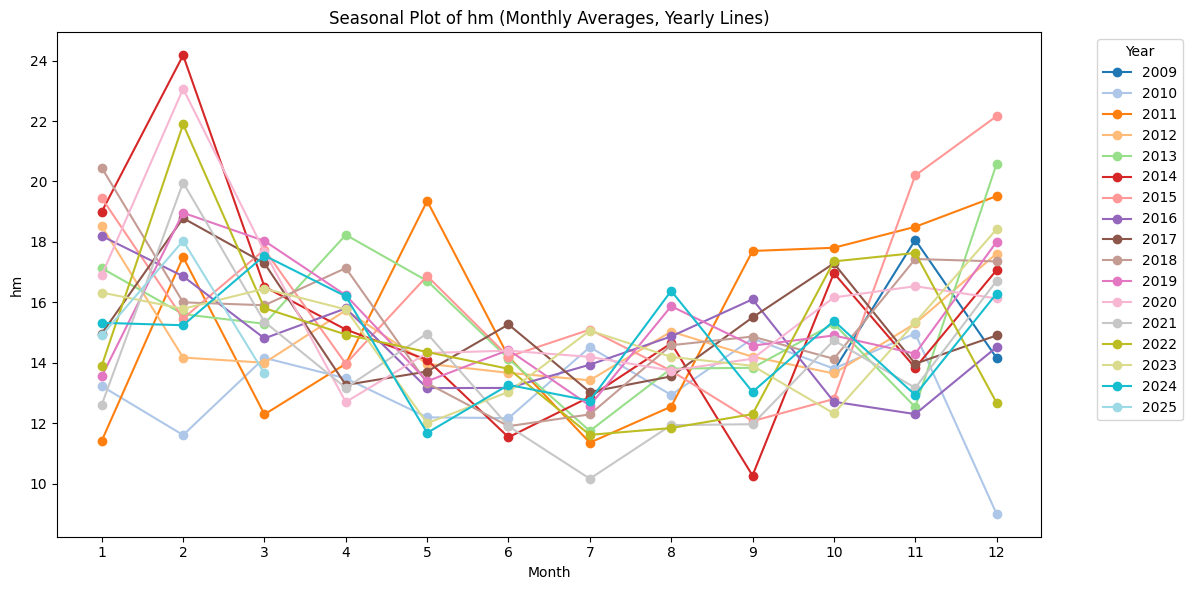

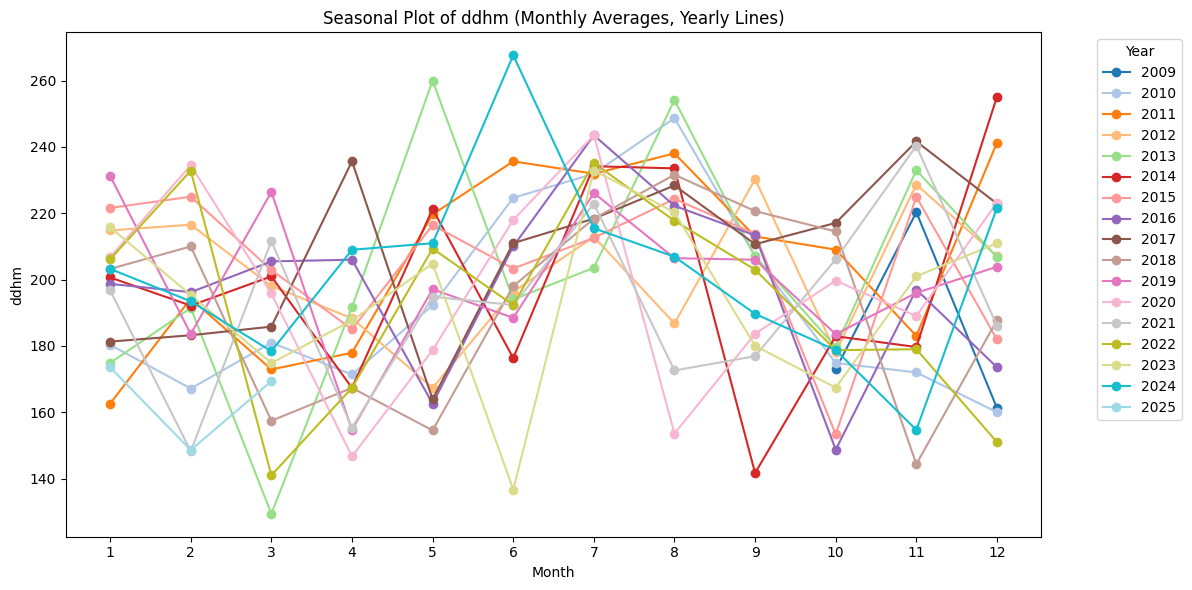

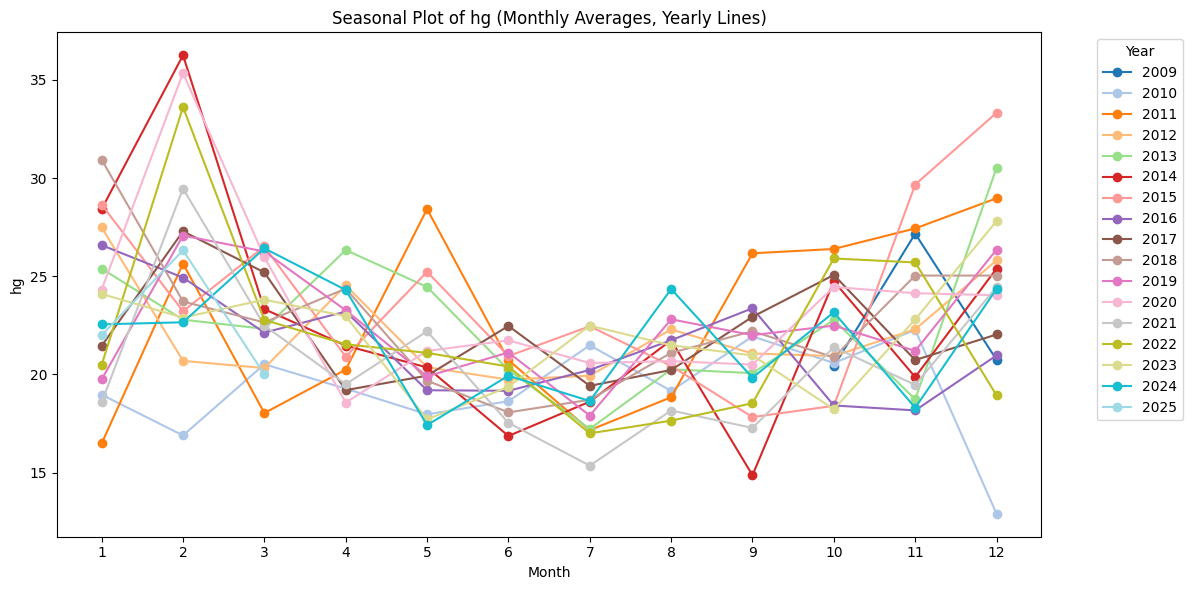

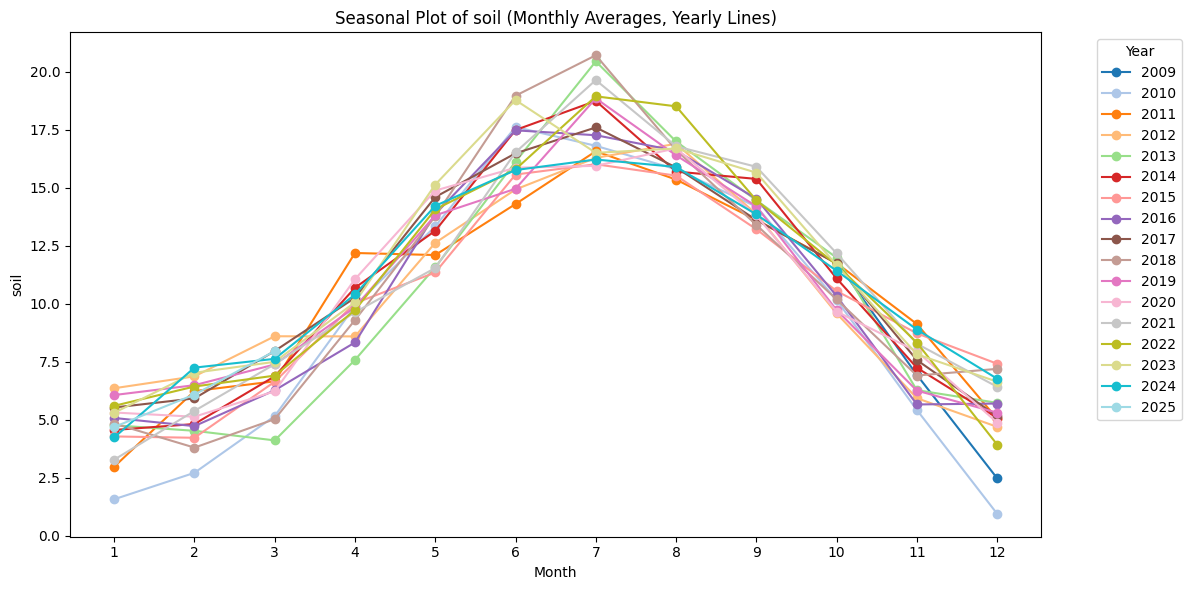

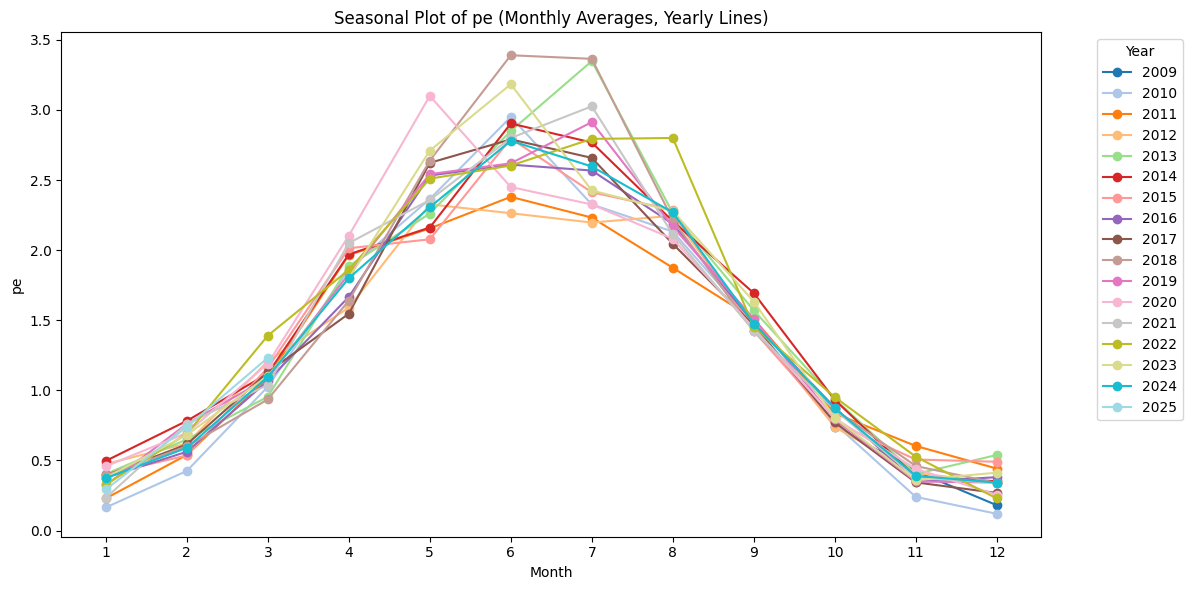

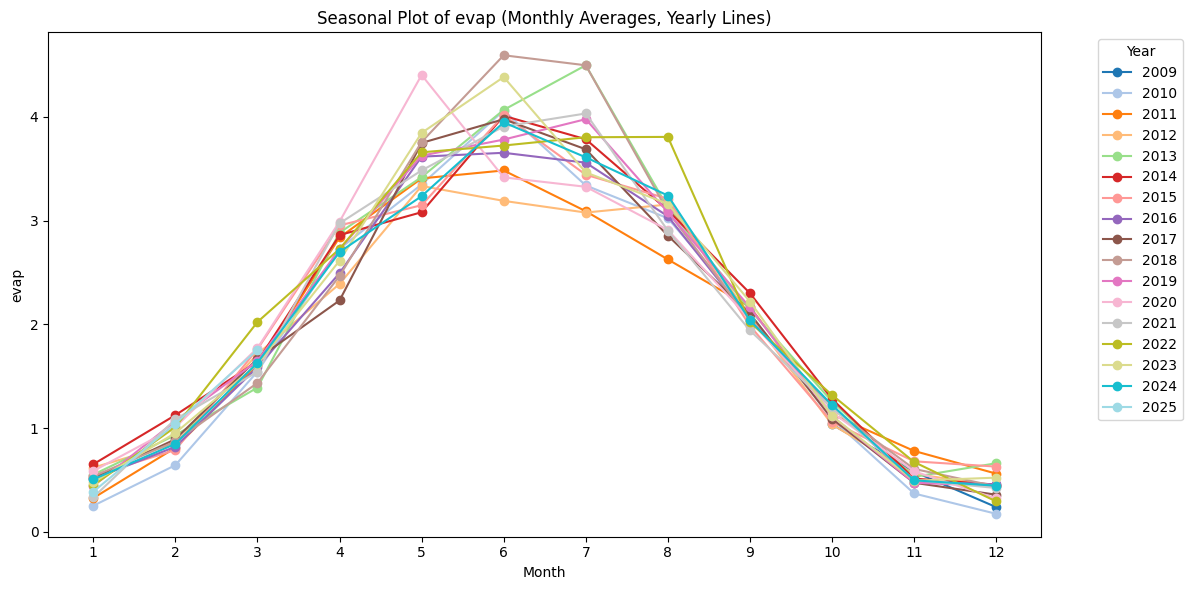

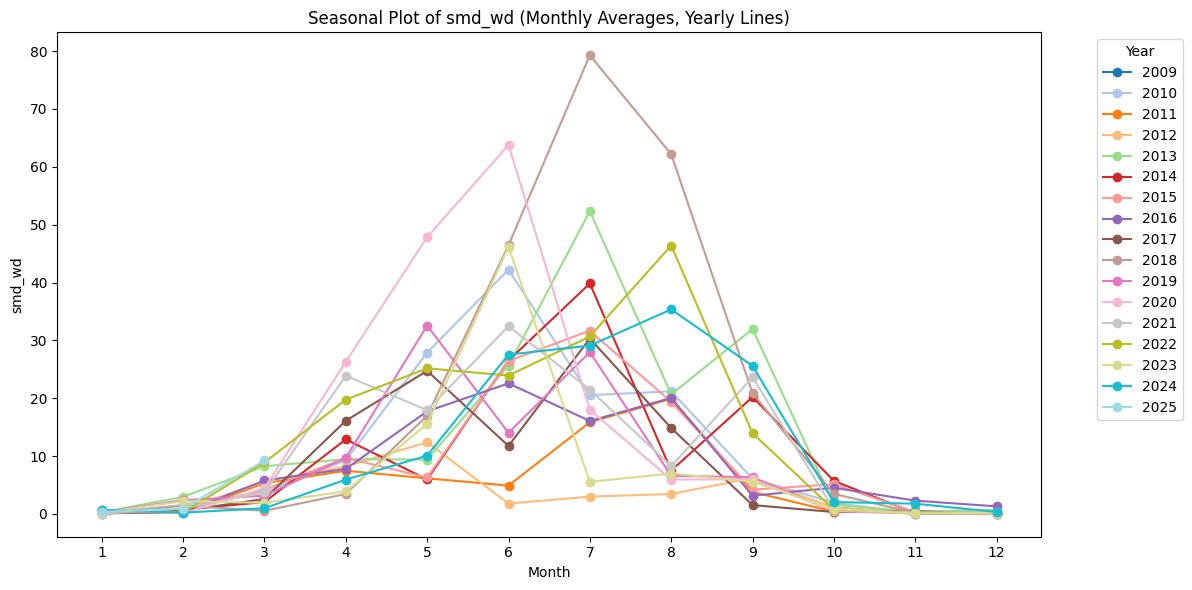

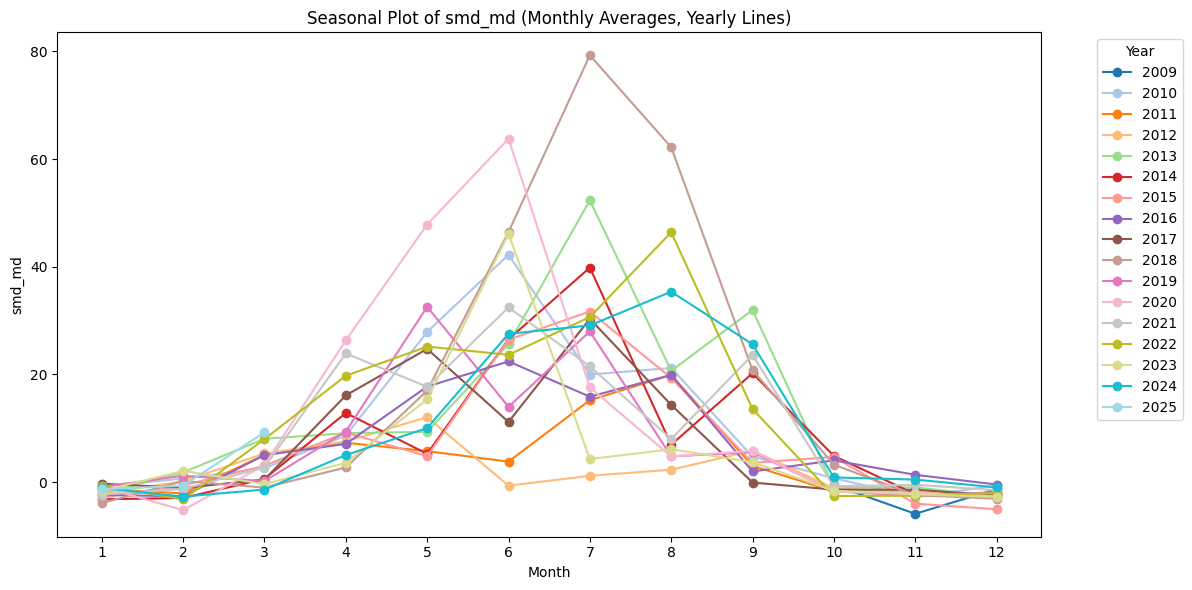

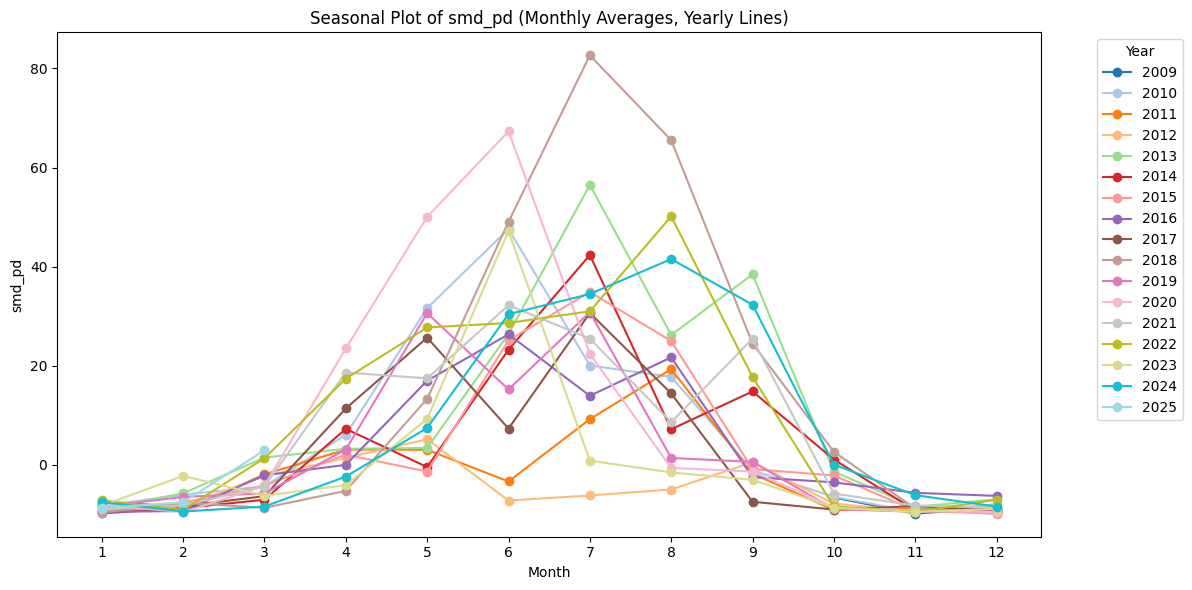

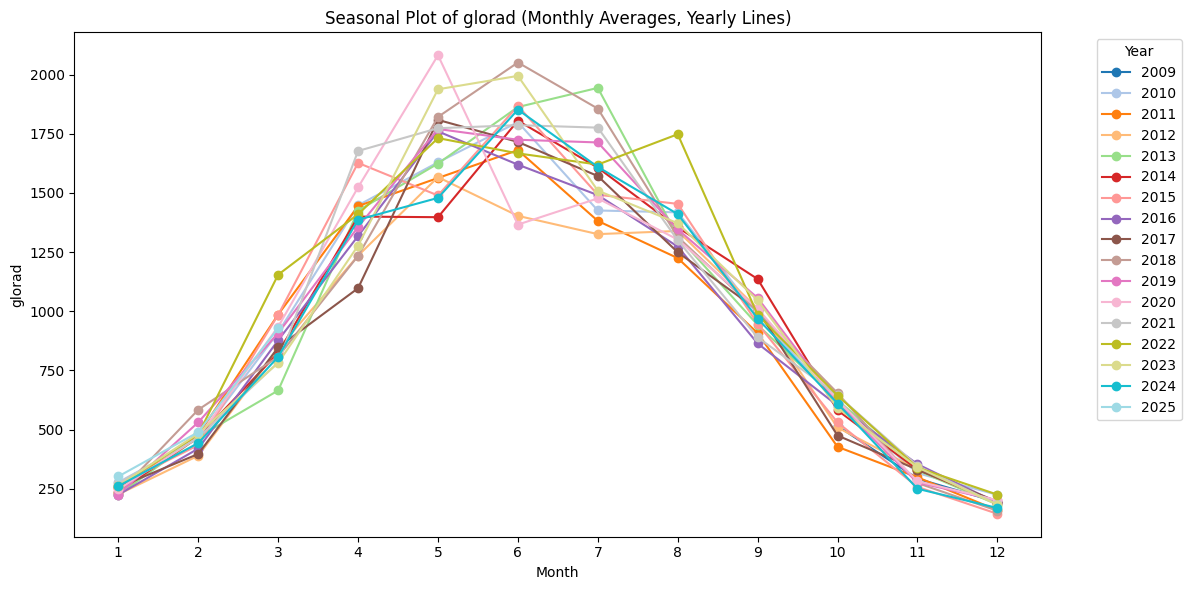

In [ ]:
for col in df_numeric.columns: #compute the plot for all the variables
    plt.figure(figsize=(12,6))
    years = sorted(df['Year'].unique())
    colors = cm.get_cmap('tab20', len(years))
    for i, year in enumerate(years): #compute the plot for each year
        group = df[df['Year'] == year]
        monthly_mean = group.groupby('Month')[col].mean()
        plt.plot(monthly_mean.index, monthly_mean.values, marker='o',
                 color=colors(i), label=str(year))
    plt.title(f'Seasonal Plot of {col} (Monthly Averages, Yearly Lines)')
    plt.xlabel('Month')
    plt.ylabel(col)
    plt.xticks(range(1,13))
    plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

According to the yearly seasonal plots of weather conditions, a noticeable pattern emerges where most variables tend to reach their maximum values between the 7th and 8th months of the year. This period typically corresponds to the summer season, when sunlight intensity and temperature are at their highest, which can influence various meteorological variables such as humidity, evaporation, and precipitation levels.

Moreover, similar fluctuations and variability patterns can be observed in the same features identified during the Base Metrics analysis, confirming the consistency of the temporal behavior across different statistical perspectives.

Many features in the dataset exhibit a high degree of correlation, particularly variables such as rain, cbl, ddhm, smd_md, smd_wd, smd_pd, and wdsp. These variables display similar temporal trends throughout the year, which is expected given their strong physical and environmental interconnections. For instance, soil moisture deficits related variables (smd_md, smd_wd, smd_pd) are naturally influenced by rainfall patterns, explaining their consistent co-movement with precipitation data.

Furthermore, the pronounced fluctuations observed in variables like rain can be attributed to the geographical characteristics of Ireland, where the weather is highly variable and strongly affected by maritime climatic conditions.

Ultimately, this analysis is limited by the fact that, due to the large amount of data, I had to plot it using the average, which undoubtedly gives more importance to certain events, such as a particularly rainy day, which increases the average of that variable. For this reason i decided to continue the analysis with **Monthly box plots**



### Box plot analysis ###
Boxplot are a useful way to identify how data are distributed

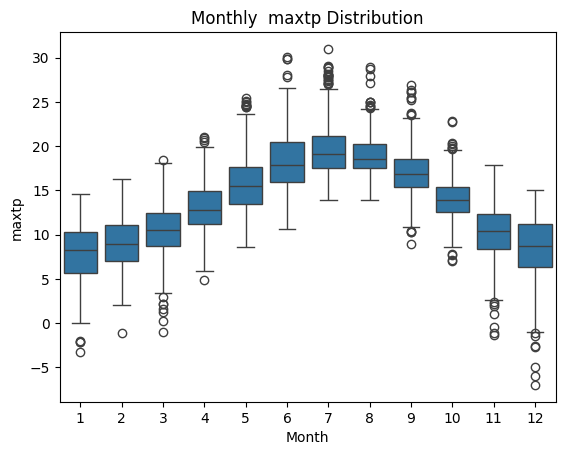

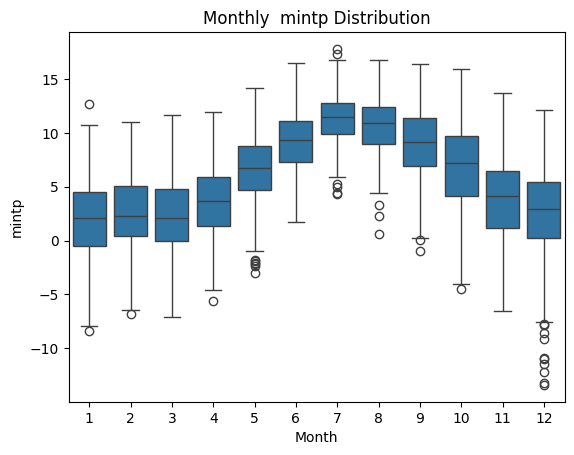

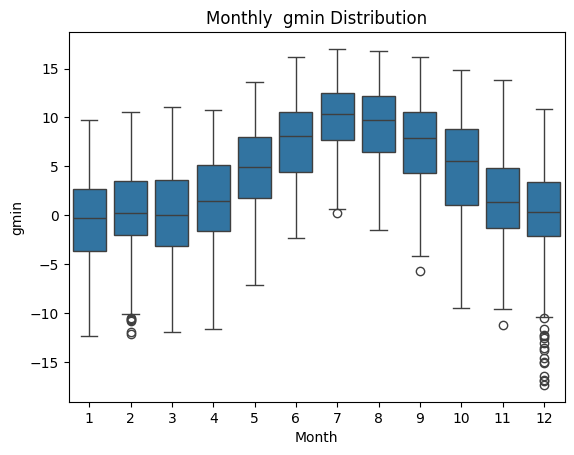

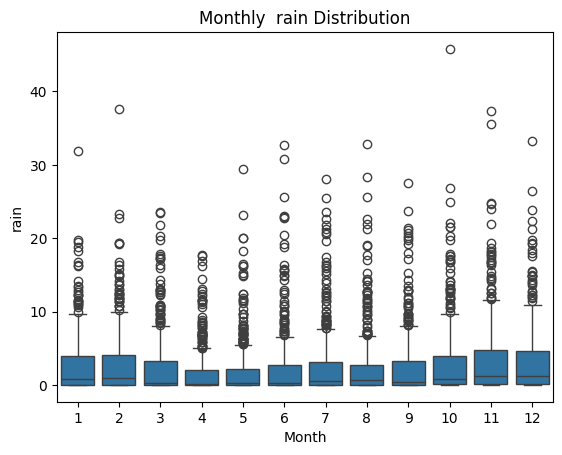

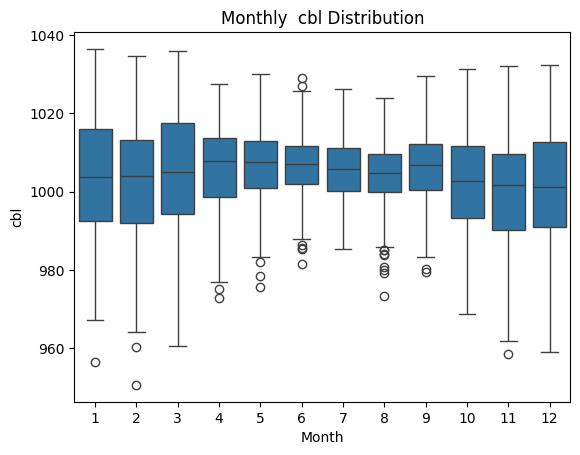

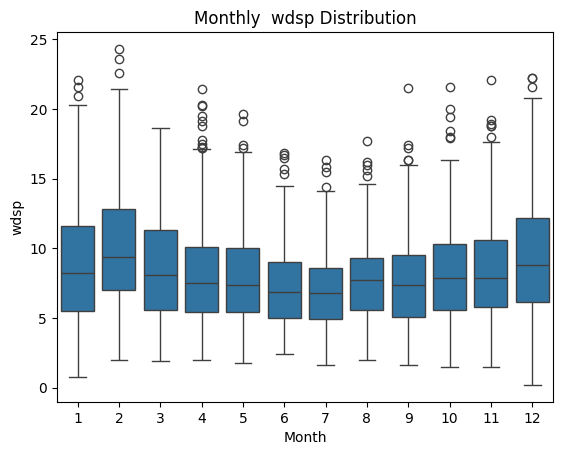

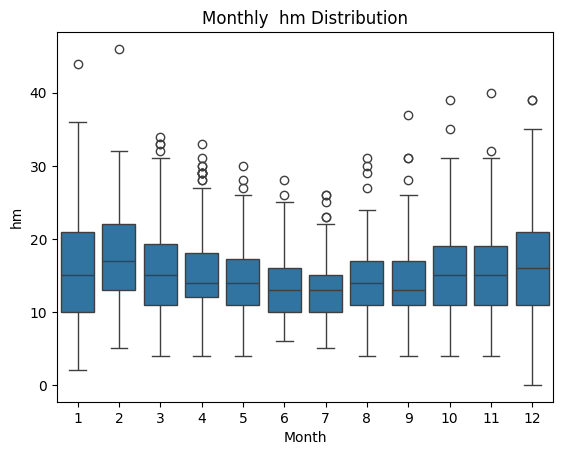

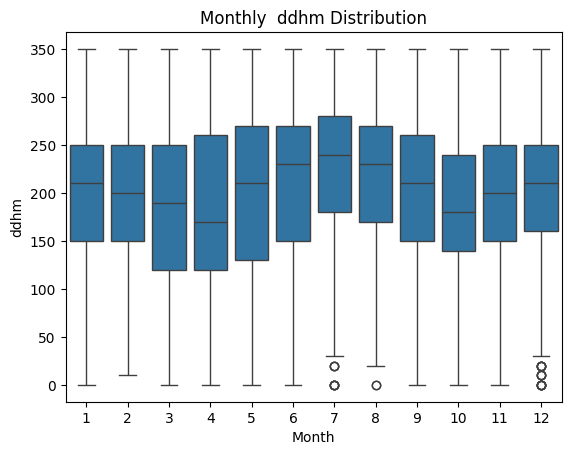

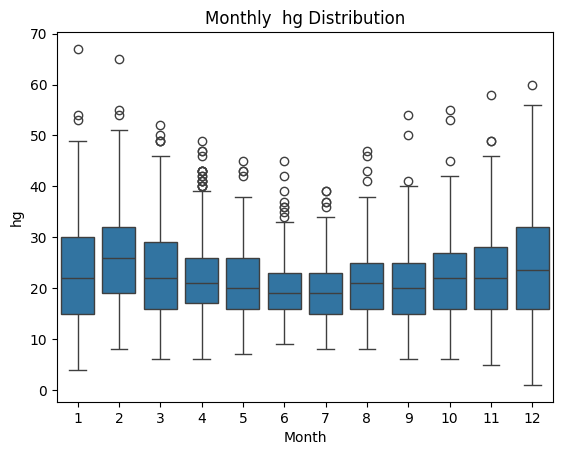

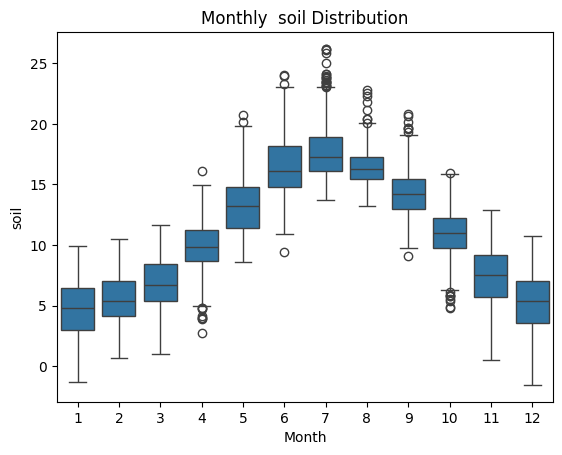

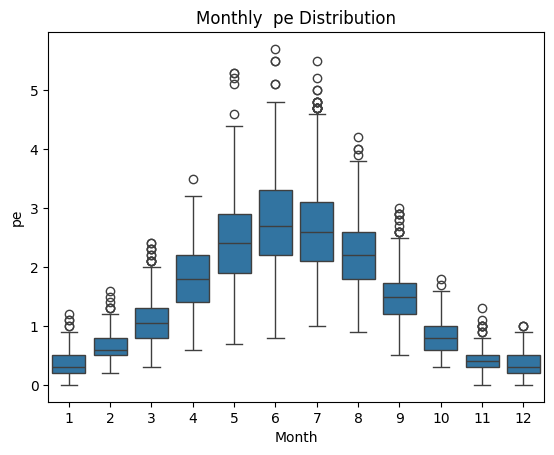

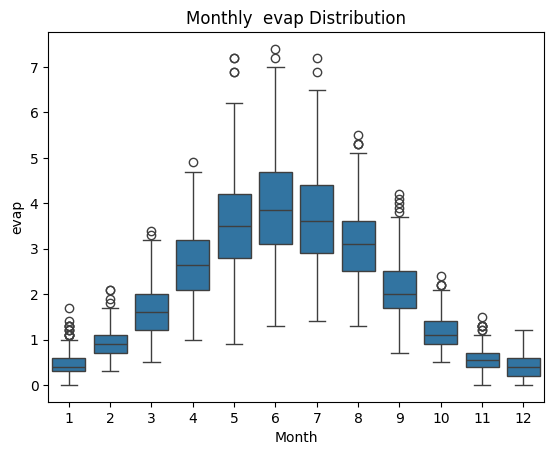

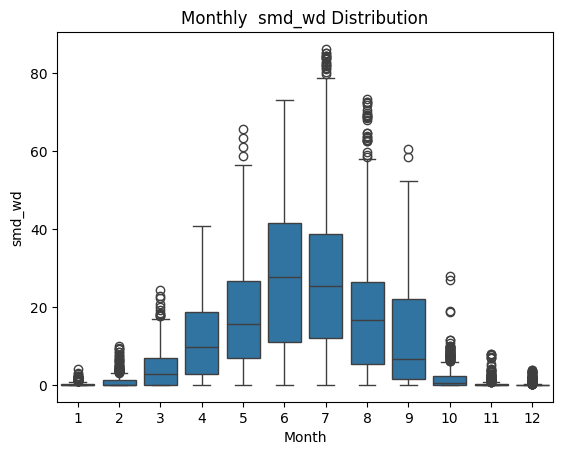

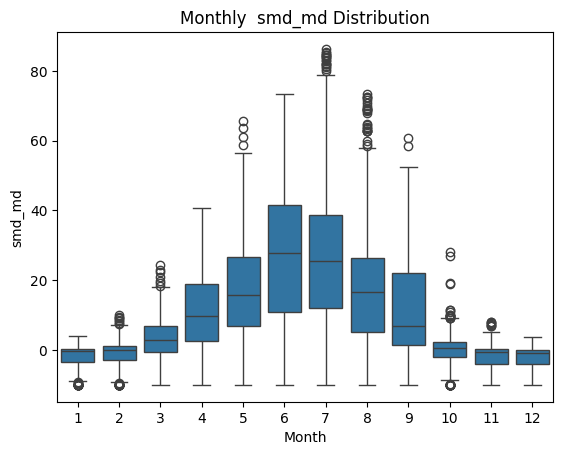

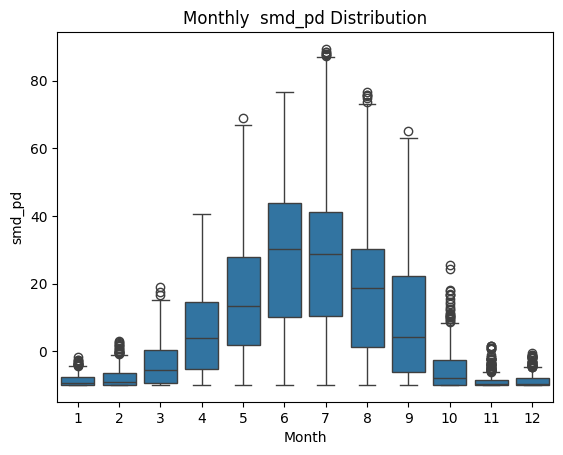

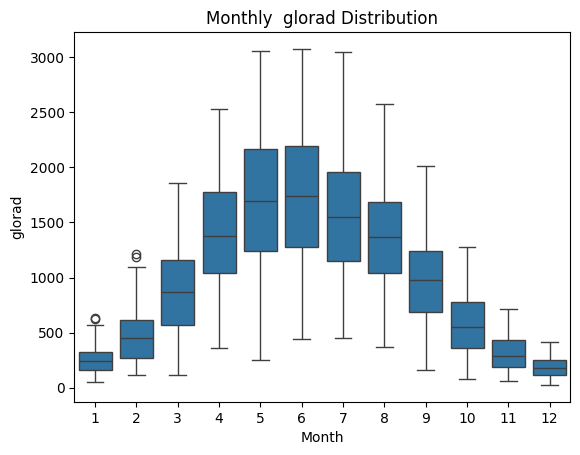

In [ ]:
for title in df_numeric.columns: #compute the box plot for all the variables
  sns.boxplot(x='Month', y=title, data=df)
  plt.title(f'Monthly  {title} Distribution')
  plt.show()

These plots confirm my earlier observations: several variables remain relatively stable within their typical ranges, showing only occasional outliers — such as glorad, evap, ddhm, cbl gmin, and maxtp. These variables also share a consistent seasonal pattern, with values peaking during the warmest months, July and August, which reflects the expected summer maximums in temperature and solar radiation for Gurteen’s temperate maritime climate.

In contrast, other variables, particularly those with the highest standard deviations, display much greater variability and a larger number of outliers most notably rain and soil moisture deficit (smd). This variability is typical of Irish weather, where precipitation can fluctuate significantly even within the same month, and soil moisture responds dynamically to short-term rainfall events and evapotranspiration changes.

Finally, an interesting feature emerging from these plots is the relative uniformity of certain parameters such as hg and ddhm, which show only minor variations throughout the year.

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df = df.drop(columns=['Year', 'Month'])
df.set_index('date', inplace=True)

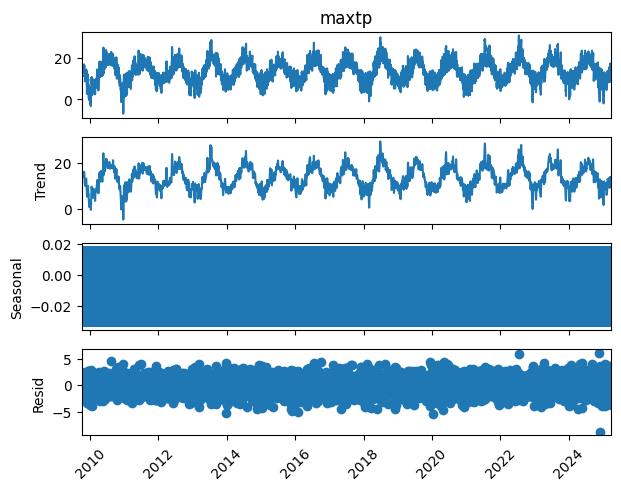

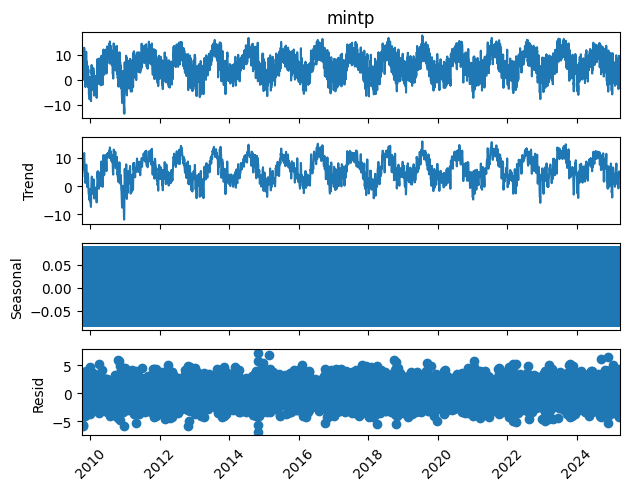

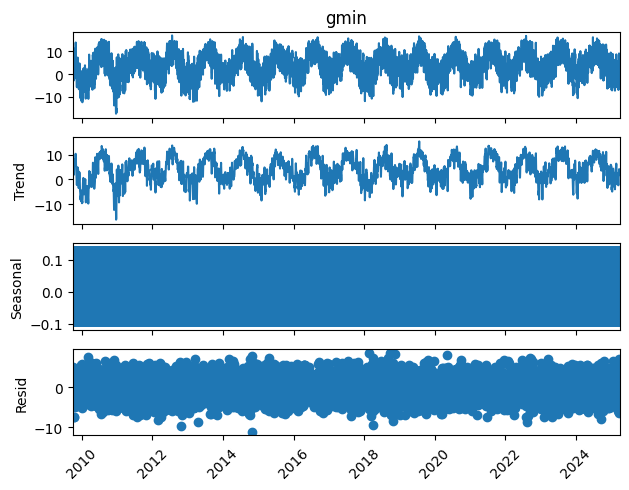

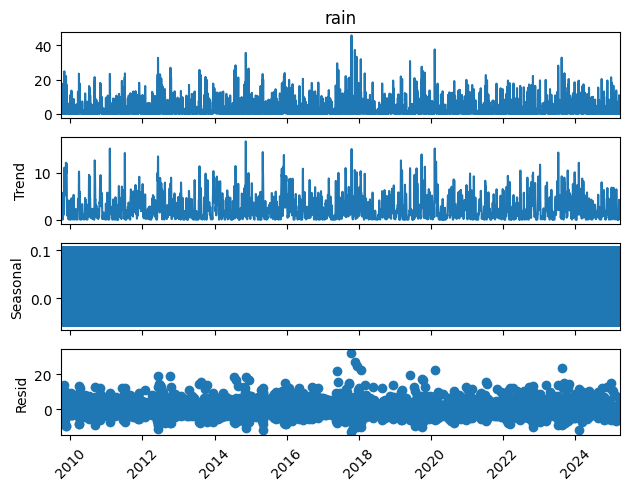

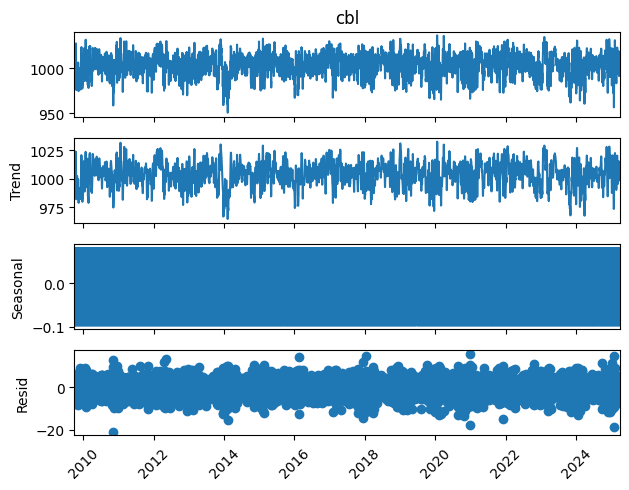

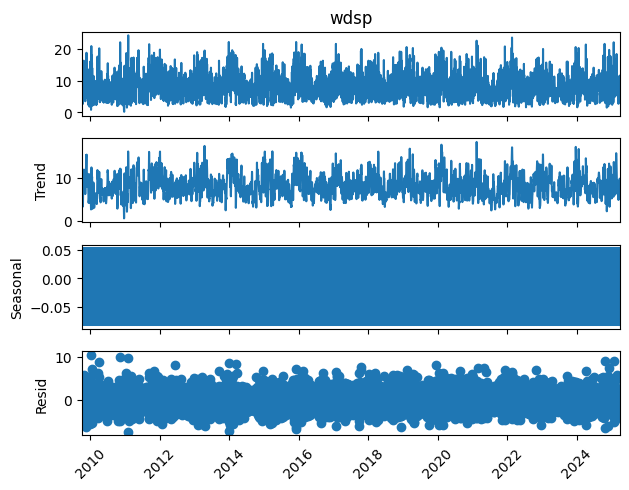

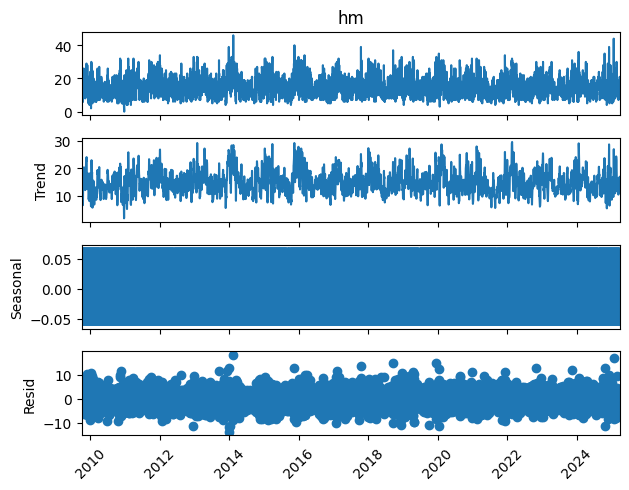

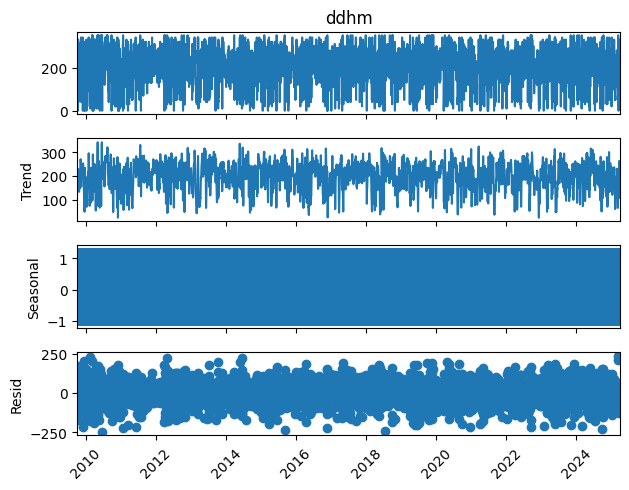

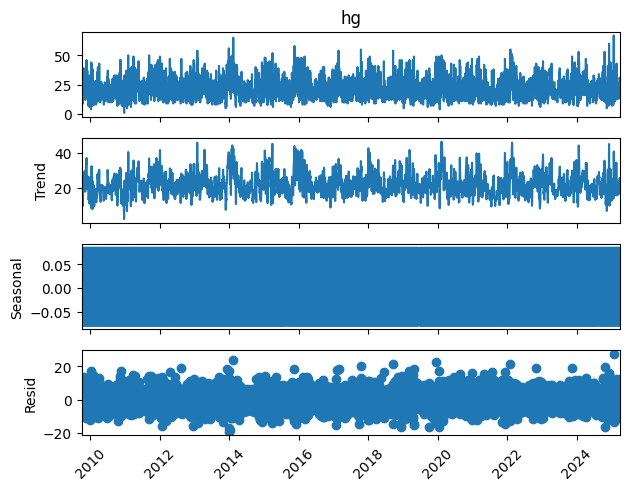

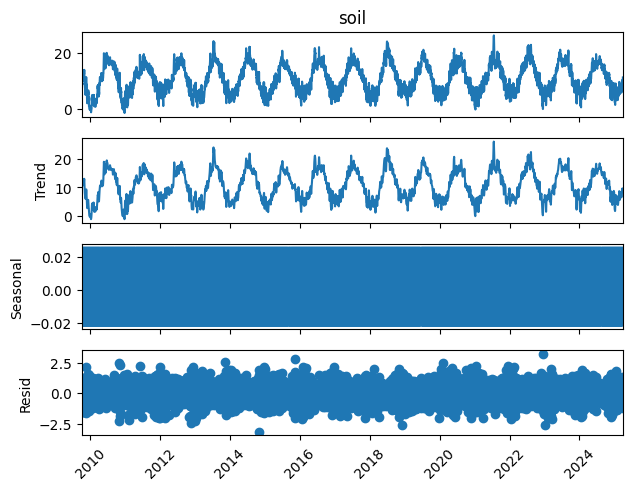

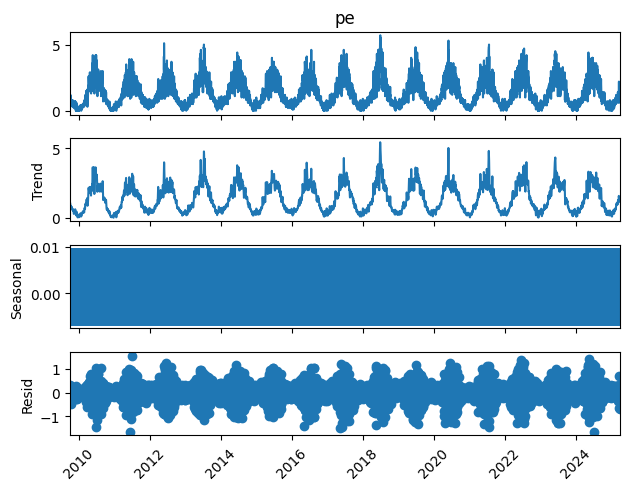

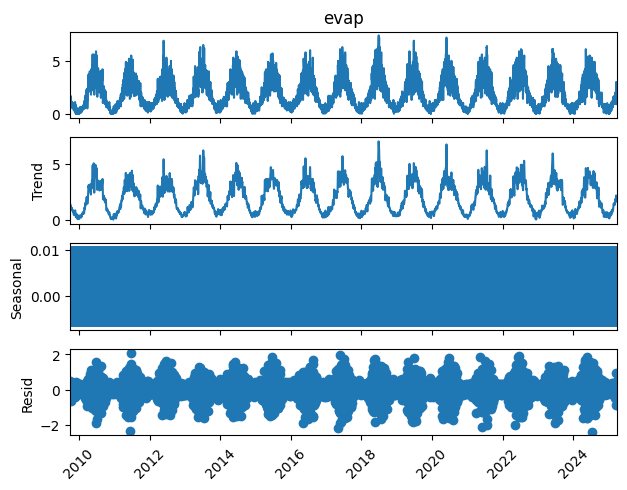

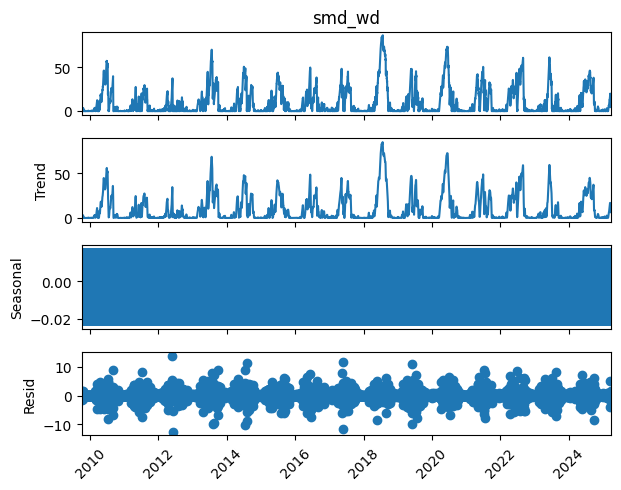

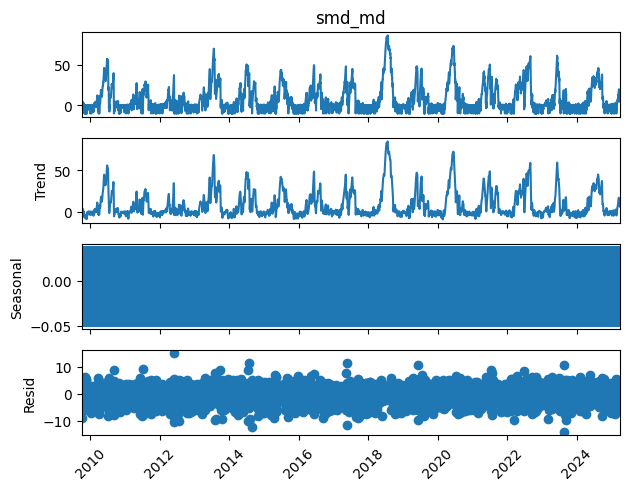

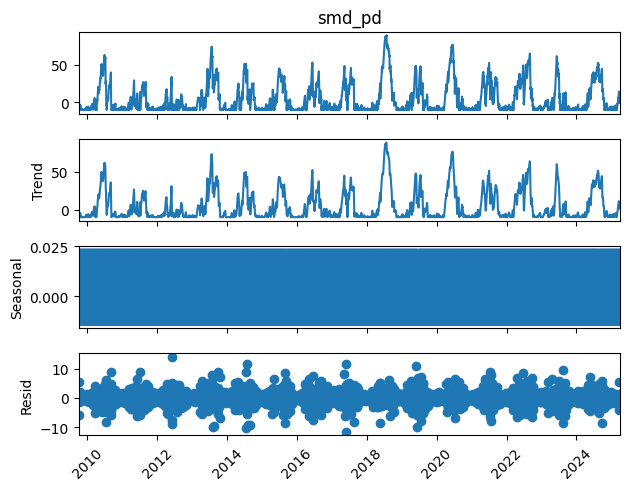

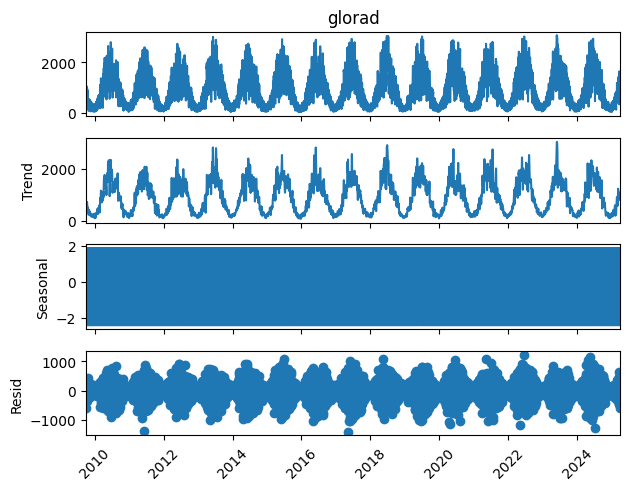

In [ ]:
for col in df.columns: #find the seasonal trends for each variable
  result = seasonal_decompose(df[col], model='additive', period=4)
  result.plot().suptitle('', fontsize=22)
  plt.xticks(rotation=45)

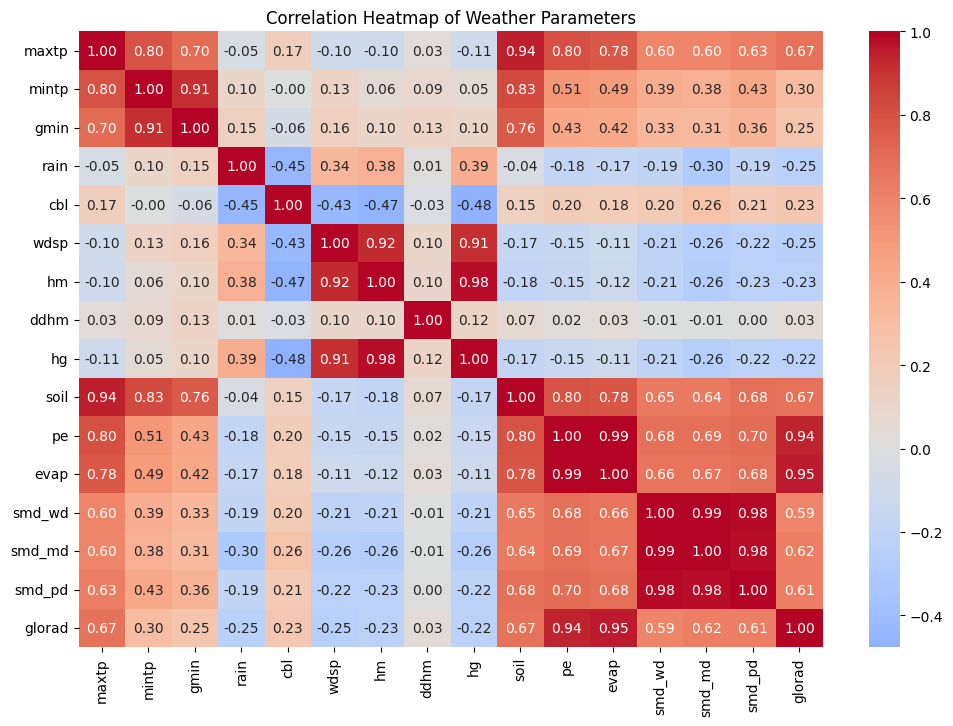

In [ ]:
corr = df.corr() # Compute correlation
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Weather Parameters")
plt.show()

The correlation matrix indicates that many variables are highly correlated with one another, which is expected since weather features are often interdependent. In particular, variables such as rainfall and soil moisture deficit (SMD) show a negative correlation — as rainfall increases, the moisture deficit decreases. Moreover, smd variables  are closely related to global radiation: the hotter and sunnier the day, the more dehydrated the soil becomes. Finally, several wind-related variables, such as wind speed (WDSP) and humidity (HM), also exhibit strong correlations among themselves.

## Train The model ##
When dealing with temporal (time-dependent) data, such as weather observations over months or years, it is essential to use a model that can capture patterns and dependencies across time — not just relationships between variables at a single moment.

The Recurrent Neural Network (RNN) is the most powerful family of models designed for this purpose.
RNNs are different from traditional feed-forward networks because they have an internal memory that allows them to remember information from previous time steps.

I chose GRU because it is the fastest RNN type to train, faster than LSTM models and other complex architectures like Transformers. GRU is also excellent at finding long-term relations.

In [ ]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df.values) # Normalize features
data_tensor = torch.tensor(data_scaled, dtype=torch.float32) # Convert to torch tensor

### Train strategy ###
Train a RNN may have many problems Training an RNN on time series data often encounters difficulties including the vanishing and exploding gradient problems, which hinder the learning of long-term dependencies. Additionally, RNNs can suffer from overfitting.
In short, I have decided to use a teacher forcing approach for the training, even though the typical approach used to achieve the best results in terms of model convergence and accuracy during inference is a mixture of teacher forcing at the start and autoregressive at the end. .


In [ ]:
class GRUForecast(nn.Module): #Define the model class
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUForecast, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x, h=None):
        out, h = self.gru(x, h)
        out = self.fc(out)

        return out, h


In [ ]:
class WeatherDataset(Dataset):#define the dataset class to divide the time series into fixed length sequences
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len
    def __len__(self):
        return len(self.data) - self.seq_len
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]
        y = self.data[idx+1:idx+self.seq_len+1]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [ ]:
n_months=2
seq_len = 30*n_months #Set the window size
split_ratio = 0.8
split_idx = int(len(data_tensor) * split_ratio) # Calculate split index in train and validation
train_data = data_tensor[:split_idx]
test_data = data_tensor[split_idx - seq_len:]
train_dataset = WeatherDataset(train_data, seq_len) #create the dataset and the dataload , for test and train
test_dataset = WeatherDataset(test_data, seq_len)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUForecast(input_size=data_tensor.shape[1], hidden_size=64, num_layers=2, output_size=data_tensor.shape[1])
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 1 #train the model
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred, _= model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch + 1) % 1 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

/tmp/ipython-input-3318704181.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


Epoch [1/1], Loss: 0.0258


### Test the model ###
evaluate the model performance generating short term forecasts predictions for 1-day and 7-day ahead.

In [ ]:
model.eval()
loss=0. #perform Predictions for one day
with torch.no_grad():
    for X, y in test_loader:
      y_pred,_=model(X)

      loss+=criterion(y_pred,y ).item()
print(f"Test Loss: {loss/len(test_loader):.4f}")

/tmp/ipython-input-3318704181.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


Test Loss: 0.0132


After training, the model demonstrates strong performance on the test set, with results comparable to those observed during training.

In [ ]:
#Generate the predictions for 7 days
steps = 7
all_preds = []
all_true = []
test_X = test_data
seq_len = test_X.shape[1]

# iterate over sequences that have enough future steps
for i in range(len(test_X) - seq_len - steps + 1):
    seq = test_X[i:i+seq_len].clone().unsqueeze(0)
    preds = []

    # autoregressive prediction
    for _ in range(steps):
        next_pred_full, _ = model(seq)
        next_pred = next_pred_full[:, -1, :]
        preds.append(next_pred[0].detach().cpu().numpy())
        next_input = seq[:, -1:, :].clone()
        next_input[:, 0, :] = next_pred
        seq = torch.cat([seq[:, 1:, :], next_input], dim=1)

    all_preds.append(preds)

    # collect true values for evaluation
    true_seq = test_X[i+seq_len:i+seq_len+steps, :].numpy()
    all_true.append(true_seq)

# convert lists to arrays
all_preds = np.array(all_preds)
all_true = np.array(all_true)
# compute MSE
mse_per_step = ((all_preds - all_true) ** 2).mean(axis=(0, 2))
overall_mse = ((all_preds - all_true) ** 2).mean()

print("MSE per step:", mse_per_step)
print("Overall MSE:", overall_mse)

MSE per step: [0.01249353 0.01412627 0.01492743 0.01550981 0.01603714 0.01638808
 0.01665249]
Overall MSE: 0.015162113


Possible future steps include exploring alternative training approaches, such as the use of transformer-based architectures, which could enhance the model’s ability to capture complex temporal dependencies and improve long-term forecast accuracy.
Additionally, a potential direction for further analysis could involve identifying recurring patterns or motifs within the data, which would provide deeper insights into the relationships and correlations among the different variables.